# Outlier Detection: Refit to single population

## Imports

In [1]:
# Python modules for numerics and scientific computing
import numpy as np
import pandas as pd
import scipy as sp

# scikit-learn

# Matplotlib
%matplotlib inline
import pickle

import mab_utils
import matplotlib
import matplotlib.pyplot as plt

# import tqdm
import interlab as inl
import interlab.utilities

Load data from processing notebook

In [2]:
jeffries = r"Symmetric Kullback-Liebler"

with open("mAb_interlab_project.sav", "rb") as f:
    mab_project = pickle.load(f)

with open("mab_analysis_accessories.sav", "rb") as f:
    (windowed_shape, jeffries, full_indices, split_point, ssi_contours, interp_map) = (
        pickle.load(f)
    )

metadata_table = pd.read_hdf("metadata_table_raw.h5", key="NMR_2D_raw", mode="r")

## Calculate probability scores and find outliers

The matrix of pairwise distances is collapsed into the vector of average distances by taking the average distance of each spectrum from each other. The population of average distances in each group is fit to a distribution (here, lognormal).

In [3]:
mab_project.fit_zscores()

Probability scores are calculated for each measurement within each group and spectra outside the 95 % confidence boundary are identified as outliers.

In [4]:
mab_project.find_outliers(recursive=False, support_fraction=0.6)

In [5]:
mab_utils.save_outlier_data(
    metadata_table, mab_project, full_indices, split_point, metric=jeffries
)

The entire set of Z-scores is then used as a single population and a new distribution is fit.

In [6]:
normalized_scores = metadata_table.Zscore.values

In [7]:
new_pop = inl.utilities.Population(
    "All spectra normalized", distribution=sp.stats.lognorm, values=normalized_scores
)

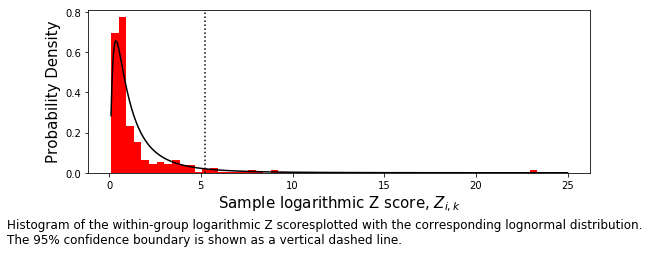

In [8]:
new_pop.fit_zscores()
new_pop.find_outliers()
f, ax = plt.subplots(figsize=(9, 3))
new_pop.histogram(ax, num_bins=60)
t = ax.set_xlabel(r"Sample logarithmic Z score, $Z_{i,k}$", size=15)
t = ax.set_ylabel("Probability Density", size=15)

caption_text = (
    "Histogram of the within-group logarithmic Z scores"
    + "plotted with the corresponding lognormal distribution. \nThe 95% "
    + "confidence boundary is shown as a vertical dashed line. "
)

width, height = f.get_size_inches()

t = f.text(0, -0.25 / height, caption_text, size=12, va="top")

### Save outlier information to metadata table

Outlier data from the interlab study is saved to our metadata table.

In [ ]:
metadata_table.Zscore = new_pop.zscores
metadata_table.Outlier = ~new_pop.outlier_mask
metadata_table.head(5)

In [10]:
plot_dict = dict(
    xlabel="$^1$H shift (ppm)",
    ylabel="$^{13}$C shift (ppm)",
    plot_corners=[1.9, -0.9, 30.5, 9],
    shape=windowed_shape,
    window=False,
    sharex=True,
    sharey=True,
    plotsize=(3, 2),
    gridspec_kw=dict(hspace=0.05, wspace=0.05),
)

contour_colors_mappable = matplotlib.cm.ScalarMappable(
    cmap=mab_utils.seismic_with_alpha.reversed()
)

contour_colormap = contour_colors_mappable.get_cmap()
contours_rescale = np.interp(ssi_contours, *interp_map)

contour_colors = contour_colormap(contours_rescale)

### False-positive outliers

/home/local/NIST/dsheen/.conda/envs/default_outside/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)


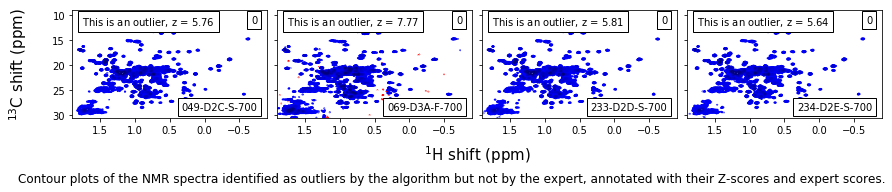

In [11]:
match_code = np.array([code.startswith("D") for code in metadata_table.ExpCode.values])
match_expert = np.array([score == 0 for score in metadata_table.ExptScore.values])
match_algori = np.array(metadata_table.Outlier)
match_outlier = np.logical_and(match_expert, match_algori)
# match_outlier =  np.logical_or(np.array(metadata_table.Outlier),np.array(metadata_table.LabOutlier))
match = np.logical_and(match_outlier, match_code)
bbox = dict(facecolor="w")

exps = metadata_table.iloc[match]
fig, axes = mab_utils.plot_the_nmr(
    exps, ncols=4, levels=ssi_contours, color=contour_colors, **plot_dict
)
ax = axes.flatten()[0]
ax.invert_xaxis()
ax.invert_yaxis()
for score, ax in zip(metadata_table.ExptScore.values[match], axes.flatten()):
    ax.text(
        0.95, 0.95, str(score), ha="right", va="top", transform=ax.transAxes, bbox=bbox
    )

caption_text = (
    "Contour plots of the NMR spectra identified as outliers by the algorithm "
    + "but not by the expert, annotated with their Z-scores and expert scores."
)
width, height = fig.get_size_inches()

t = fig.text(0, -0.25 / height, caption_text, size=12, va="top")

### Expert level-2 outliers

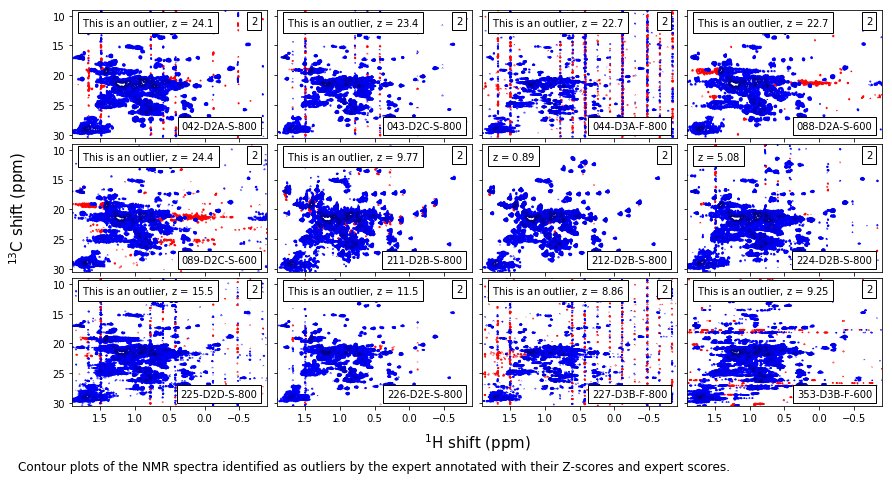

In [12]:
match_code = np.array([code.startswith("D") for code in metadata_table.ExpCode.values])
match_outlier = np.array([score > 1 for score in metadata_table.ExptScore.values])
# match_outlier =  np.logical_or(np.array(metadata_table.Outlier),np.array(metadata_table.LabOutlier))
match = np.logical_and(match_outlier, match_code)
bbox = dict(facecolor="w")

exps = metadata_table.iloc[match]
fig, axes = mab_utils.plot_the_nmr(
    exps, ncols=4, levels=ssi_contours, color=contour_colors, **plot_dict
)
ax = axes.flatten()[0]
ax.invert_xaxis()
ax.invert_yaxis()
for score, ax in zip(metadata_table.ExptScore.values[match], axes.flatten()):
    ax.text(
        0.95, 0.95, str(score), ha="right", va="top", transform=ax.transAxes, bbox=bbox
    )

caption_text = (
    "Contour plots of the NMR spectra identified as outliers by the expert "
    + "annotated with their Z-scores and expert scores."
)
width, height = fig.get_size_inches()

t = fig.text(0, -0.25 / height, caption_text, size=12, va="top")

### Expert level-1 outliers

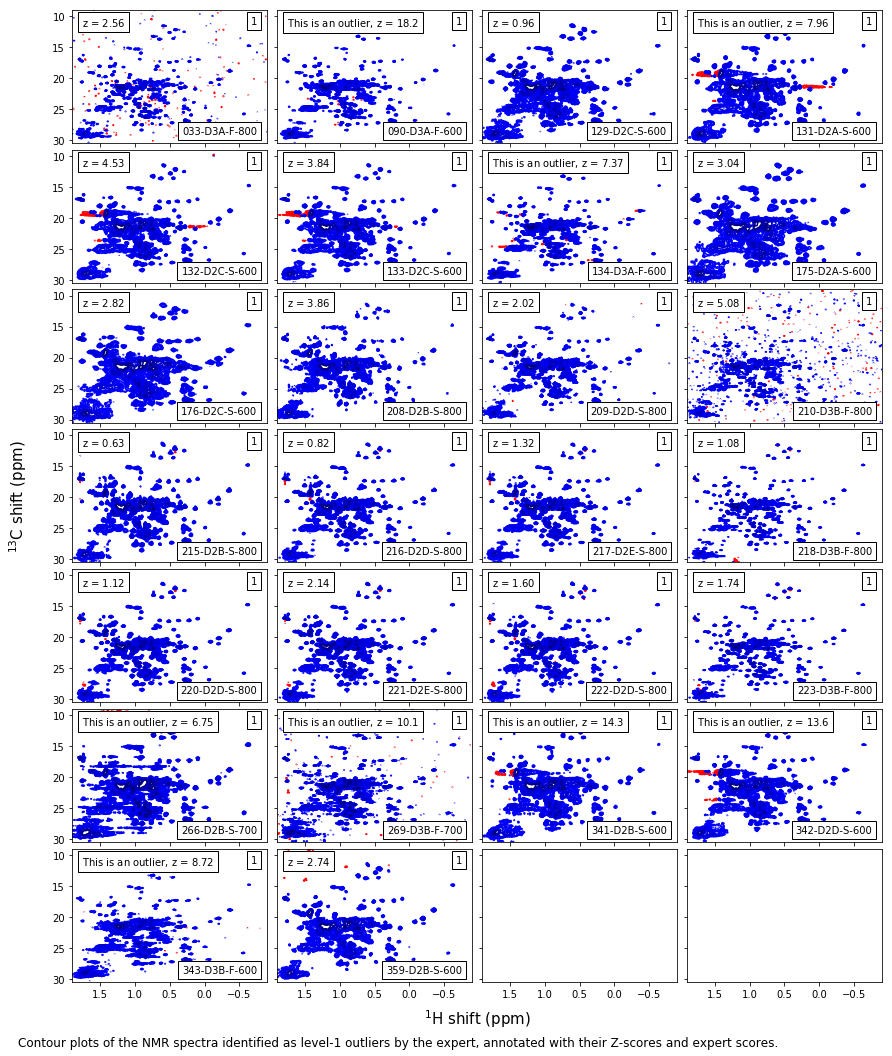

In [13]:
match_code = np.array([code.startswith("D") for code in metadata_table.ExpCode.values])
match_outlier = np.array([score == 1 for score in metadata_table.ExptScore.values])
# match_outlier =  np.logical_or(np.array(metadata_table.Outlier),np.array(metadata_table.LabOutlier))
match = np.logical_and(match_outlier, match_code)
bbox = dict(facecolor="w")

exps = metadata_table.iloc[match]
fig, axes = mab_utils.plot_the_nmr(
    exps, ncols=4, levels=ssi_contours, color=contour_colors, **plot_dict
)
ax = axes.flatten()[0]
ax.invert_xaxis()
ax.invert_yaxis()
for score, ax in zip(metadata_table.ExptScore.values[match], axes.flatten()):
    ax.text(
        0.95, 0.95, str(score), ha="right", va="top", transform=ax.transAxes, bbox=bbox
    )

caption_text = (
    "Contour plots of the NMR spectra identified as level-1 outliers by "
    + "the expert, annotated with their Z-scores and expert scores."
)

width, height = fig.get_size_inches()

t = fig.text(0, -0.25 / height, caption_text, size=12, va="top")

In [14]:
metadata_table.to_csv("metadata_table_single-pop.csv", sep="\t")